In [43]:
import sys
sys.path.append("./findrl_ray/finrl")
from env_stocktrading import StockTradingEnv
from preprocessors import data_split

#from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
#from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split

import pandas as pd
import pickle 

# load the DataFrame from a pickle file
df = pd.read_pickle('dataset/processed.pkl')
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-01-01'
TRADE_START_DATE = '2021-01-02'
TRADE_END_DATE = '2023-03-24'

In [2]:
INDICATORS = ['macd','rsi_14', 'rsi_21','rsi_28',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [3]:
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env

from gymnasium.wrappers import EnvCompatibility

In [4]:
train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

80301
16211


In [5]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 378


In [6]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [7]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

In [8]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))

In [9]:
from ray.rllib.agents import ppo
ray.shutdown()

In [10]:
use_ddppo = False
config = ppo.PPOConfig() 

In [11]:
# registering the environment to ray
register_env("finrl_trading", env_creator_trading)
# define trainer
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl_trading', config=config)
else:
    #trainer = ppo.PPOTrainer(env='finrl_trading', config=config)f
    trainer = config.build(env="finrl")

2023-03-30 11:49:59,096	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
2023-03-30 11:50:05,075	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
(RolloutWorker pid=2454) 2023-03-30 11:50:10,813	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=2454) 2023-03-30 11:50:10,814	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=2454) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarn

In [12]:
# load saved agent
#cwd_checkpoint = f"results/checkpoints/ppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
#print(f"Restoring from checkpoint {total_episodes+1}")
cwd_checkpoint = 'results/checkpoints/ppo_101/checkpoint_000106'
trainer.restore(cwd_checkpoint)

2023-03-30 11:50:24,498	INFO trainable.py:791 -- Restored on 172.24.67.242 from checkpoint: results/checkpoints/ppo_101/checkpoint_000106
2023-03-30 11:50:24,499	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 106, '_timesteps_total': None, '_time_total': 1021.3191854953766, '_episodes_total': 152}


In [13]:
import time 
def DRL_prediction(model, environment):
    start = time.time()
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state)
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            break
    print("Test Finished!")
    print((time.time()-start),'s')
    return account_memory, actions_memory

In [14]:
df_account_value, df_actions = DRL_prediction(
    model=trainer, 
    environment = e_trade_gym)

Test Finished!
1.9907281398773193 s


In [15]:
df_account_value.tail()

,date,account_value
554,2023-03-17,1.024715e+06
555,2023-03-20,1.033463e+06
556,2023-03-21,1.047832e+06
557,2023-03-22,1.033789e+06
558,2023-03-23,1.037628e+06


In [16]:
df_actions.tail(100)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2022-10-27,-100,100,100,0,-5,-30,-2,0,-1,0,...,-40,0,0,-100,0,0,0,0,-7,0
2022-10-28,0,-43,80,-1,0,0,0,0,1,0,...,-60,62,100,-44,-100,0,26,99,0,-100
2022-10-31,0,-55,100,0,0,55,5,0,-1,0,...,0,76,-82,100,-100,0,-26,40,0,0
2022-11-01,0,0,-31,0,0,0,-5,0,100,0,...,0,-8,0,-95,-100,25,0,2,0,0
2022-11-02,0,0,71,0,0,-14,0,0,0,0,...,0,-88,0,-1,-100,-25,0,-21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16,0,-34,0,0,0,0,0,0,0,0,...,0,-23,0,0,0,50,0,2,0,0
2023-03-17,0,92,0,0,0,-19,0,0,-81,0,...,0,100,0,0,0,-50,-35,-31,0,0
2023-03-20,0,-46,-66,0,0,0,0,0,-19,0,...,-32,100,0,0,-13,0,0,-69,0,100


In [17]:
df_actions.sum()

AAPL       0
AMGN      38
AXP     2221
BA         0
CAT       36
CRM        0
CSCO       0
CVX        0
DIS        0
GS         0
HD         0
HON        0
IBM        0
INTC       0
JNJ     2764
JPM        0
KO         0
MCD        0
MMM       11
MRK      204
MSFT     561
NKE      100
PG         0
TRV        0
UNH        0
V        142
VZ       200
WBA        0
WMT       87
dtype: int64

In [18]:
df_actions.to_csv('actions3.csv', index=False)

In [19]:
import datetime
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.016791
Cumulative returns     0.037628
Annual volatility      0.153656
Sharpe ratio           0.185255
Calmar ratio           0.105304
Stability              0.019884
Max drawdown          -0.159451
Omega ratio            1.031210
Sortino ratio          0.264293
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.016985
Daily value at risk   -0.019246
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [20]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (558, 8)
Annual return          0.026560
Cumulative returns     0.059761
Annual volatility      0.163547
Sharpe ratio           0.242307
Calmar ratio           0.121052
Stability              0.037858
Max drawdown          -0.219408
Omega ratio            1.041677
Sortino ratio          0.339596
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.933170
Daily value at risk   -0.020448
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (558, 8)


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2021-01-04
End date,2023-03-23
Total months,26
,Backtest
Annual return,1.679%
Cumulative returns,3.763%
Annual volatility,15.366%
Sharpe ratio,0.19
Calmar ratio,0.11
Stability,0.02
Max drawdown,-15.945%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.95,2022-04-20,2022-09-30,NaT,NaN
1,7.56,2022-02-09,2022-02-24,2022-03-29,35
2,7.51,2021-08-16,2021-12-01,2022-01-03,101
3,5.69,2022-01-04,2022-01-24,2022-02-08,26
4,3.94,2021-02-24,2021-02-26,2021-03-10,11


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'ob

Stress Events,mean,min,max
New Normal,0.01%,-3.12%,3.33%


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


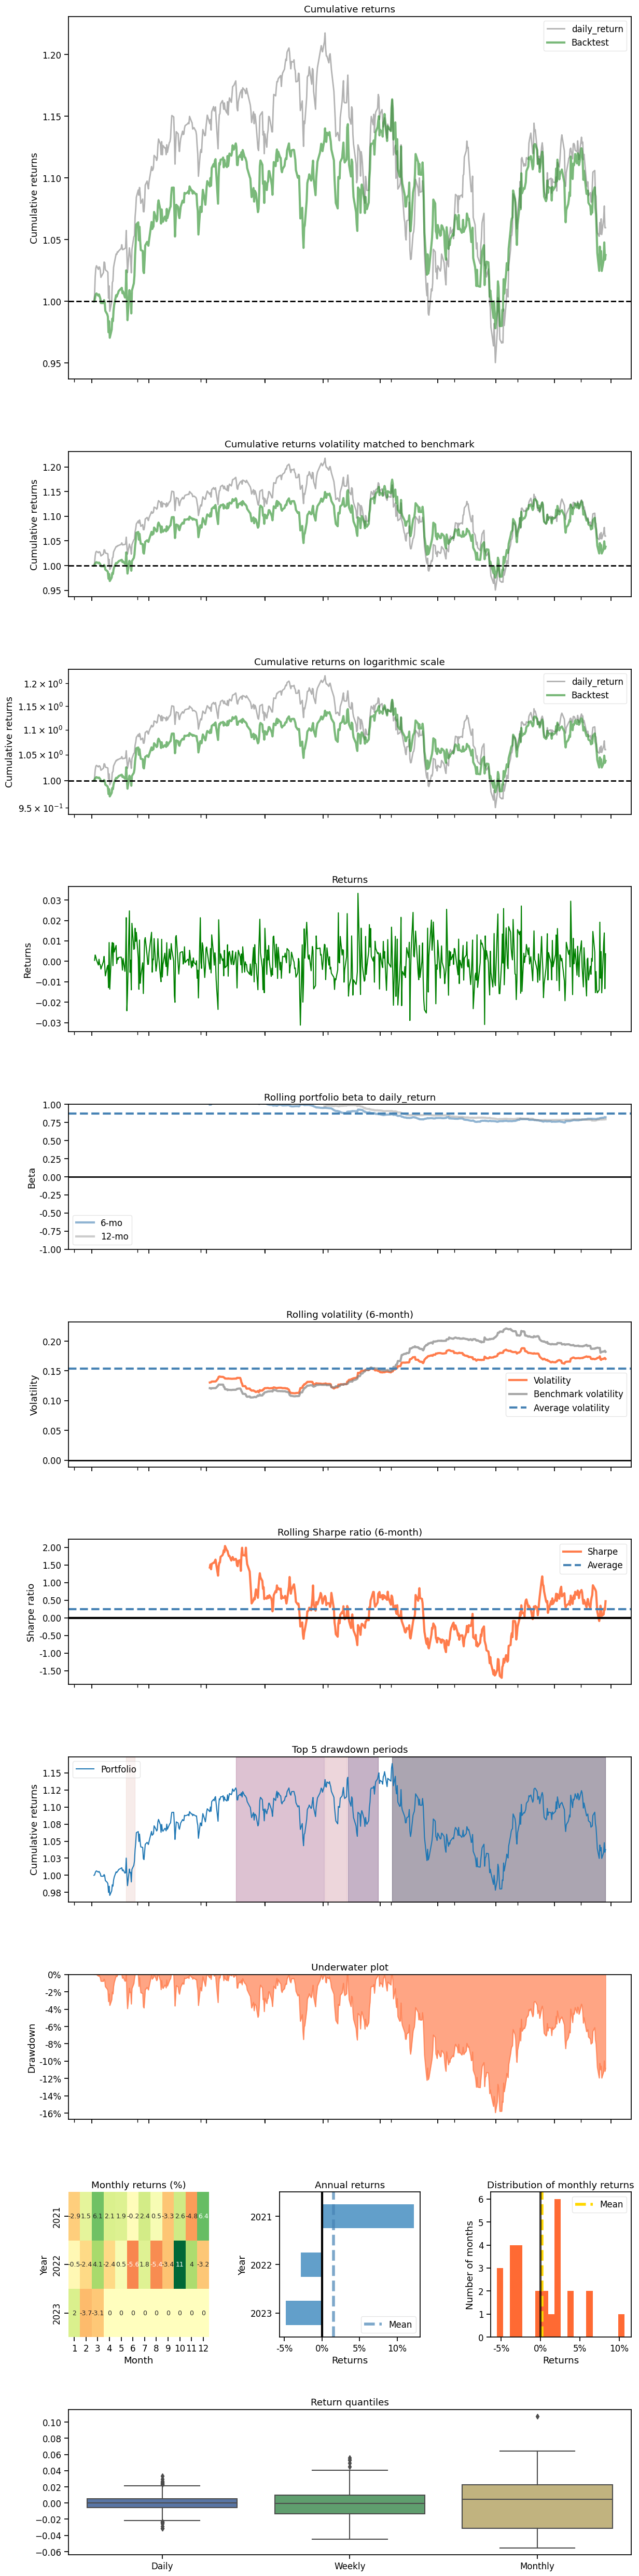

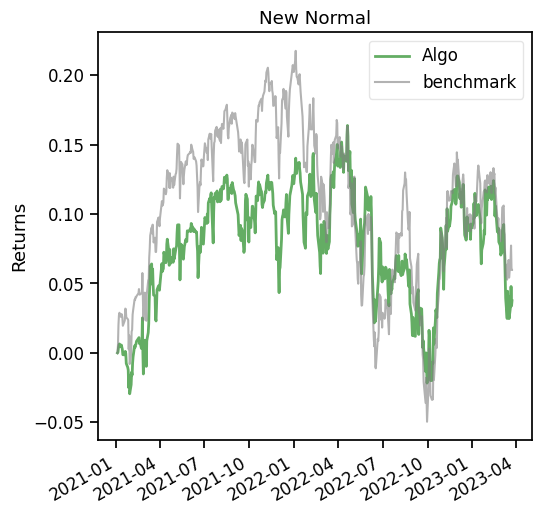

In [21]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])